In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### North Americanbird vocalizations
Source:
- https://zenodo.org/record/1250690#.XQAO_G9KjUI
- https://www.sciencedirect.com/science/article/pii/S157495411630231X
- https://ieeexplore.ieee.org/document/8462156

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import IPython

In [3]:
from avgn_paper.signalprocessing import spectrogramming as sg

In [4]:
import pdb
from joblib import Parallel, delayed
n_jobs = 10
verbosity = 5

In [5]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [7]:
DSLOC = Path('/mnt/cube/Datasets/NABirdSpecies/North American bird species/')
DSLOC

PosixPath('/mnt/cube/Datasets/NABirdSpecies/North American bird species')

In [9]:
wav_list = list(DSLOC.expanduser().glob('*/*.wav'))
wav_list[:3], len(wav_list)

([PosixPath('/mnt/cube/Datasets/NABirdSpecies/North American bird species/S3(Great Blue Heron)/s (19).wav'),
  PosixPath('/mnt/cube/Datasets/NABirdSpecies/North American bird species/S3(Great Blue Heron)/s (52).wav'),
  PosixPath('/mnt/cube/Datasets/NABirdSpecies/North American bird species/S3(Great Blue Heron)/s (242).wav')],
 3101)

In [41]:
wav_df = pd.DataFrame(columns = ['species', 'wavloc', 'wavnum','audio', 'rate', 'syll_len'])
for wf in tqdm(wav_list):
    wavnum = int(wf.stem.split('(')[1][:-1])
    species = wf.parent.stem.split('(')[1][:-1]
    rate, data = load_wav(wf)
    wav_df.loc[len(wav_df)] = [species, wf, wavnum, data, rate, len(data)/rate]

In [42]:
wav_df[:3]

species                                             wavloc wavnum  \
0  Great Blue Heron  /mnt/cube/Datasets/NABirdSpecies/North America...     19   
1  Great Blue Heron  /mnt/cube/Datasets/NABirdSpecies/North America...     52   
2  Great Blue Heron  /mnt/cube/Datasets/NABirdSpecies/North America...    242   

                                               audio   rate  syll_len  
0  [170, 156, 159, 147, 130, 129, 110, 87, 63, 20...  32000  0.390031  
1  [317, 308, 309, 256, 199, 136, 124, 120, 142, ...  32000  0.250031  
2  [-155, -151, -52, -112, -49, -87, -95, -168, -...  32000  0.290031

In [43]:
wav_df.rate.unique()

array([32000], dtype=object)

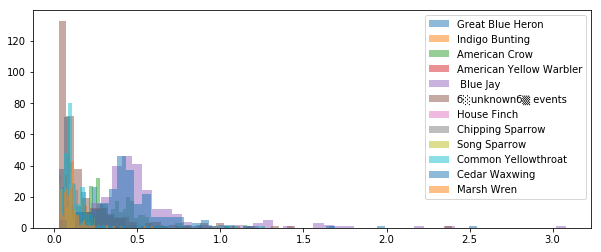

In [47]:
fig, ax = plt.subplots(figsize=(10,4))
for species in wav_df.species.unique():
    ax.hist(wav_df[wav_df.species == species].syll_len.values, bins=50, label = species, alpha = 0.5)
ax.legend()

In [48]:
len(wav_df)

3101

In [49]:
wav_df.species.unique()

array(['Great Blue Heron', 'Indigo Bunting', 'American Crow',
       'American Yellow Warbler', ' Blue Jay', 'б░unknownб▒ events',
       'House Finch', 'Chipping Sparrow', 'Song Sparrow',
       'Common Yellowthroat', 'Cedar Waxwing', 'Marsh Wren'], dtype=object)

In [50]:
def prepare_mel_matrix(hparams, return_numpy=True):
    # create a filter to convolve with the spectrogram
    mel_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=hparams.num_mel_bins,
        num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
        sample_rate=rate,
        lower_edge_hertz=hparams.mel_lower_edge_hertz,
        upper_edge_hertz=hparams.mel_upper_edge_hertz,
        dtype=tf.dtypes.float32,
        name=None,
    )
    
    # gets the center frequencies of mel bands
    mel_f = mel_frequencies(
        n_mels=hparams.num_mel_bins + 2,
        fmin=hparams.mel_lower_edge_hertz,
        fmax=hparams.mel_upper_edge_hertz,
    )

    # Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
    enorm = tf.dtypes.cast(
        tf.expand_dims(
            tf.constant(
                2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
            ),
            0,
        ),
        tf.float32,
    )

    mel_matrix = tf.multiply(mel_matrix, enorm)
    mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))
    if return_numpy:
        return mel_matrix.numpy()
    else:
        return mel_matrix

In [71]:
win_length_ms = 10
hop_length_ms = 2
print(win_length_ms / 1000 * rate)
print(hop_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=1024,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-60,
    preemphasis=0.97,
    # mel scaling
    num_mel_bins=64,
    mel_lower_edge_hertz=1000,
    mel_upper_edge_hertz=15000,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)
mel_matrix = prepare_mel_matrix(hparams)

320.0
64.0


In [72]:
rate

32000

In [73]:
audio = int16_to_float32(wav_df[(wav_df.species == 'American Yellow Warbler')].audio.values[0])
audio = butter_bandpass_filter(audio, lowcut = 500, highcut=15000, fs=rate, order=4)
spectrogram = sg.spectrogram(audio, hparams)
mel_spec = np.dot(spectrogram.T, mel_matrix).T

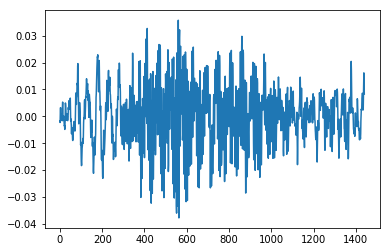

In [74]:
plt.plot(audio)
IPython.display.Audio(data=audio, rate=rate/10)

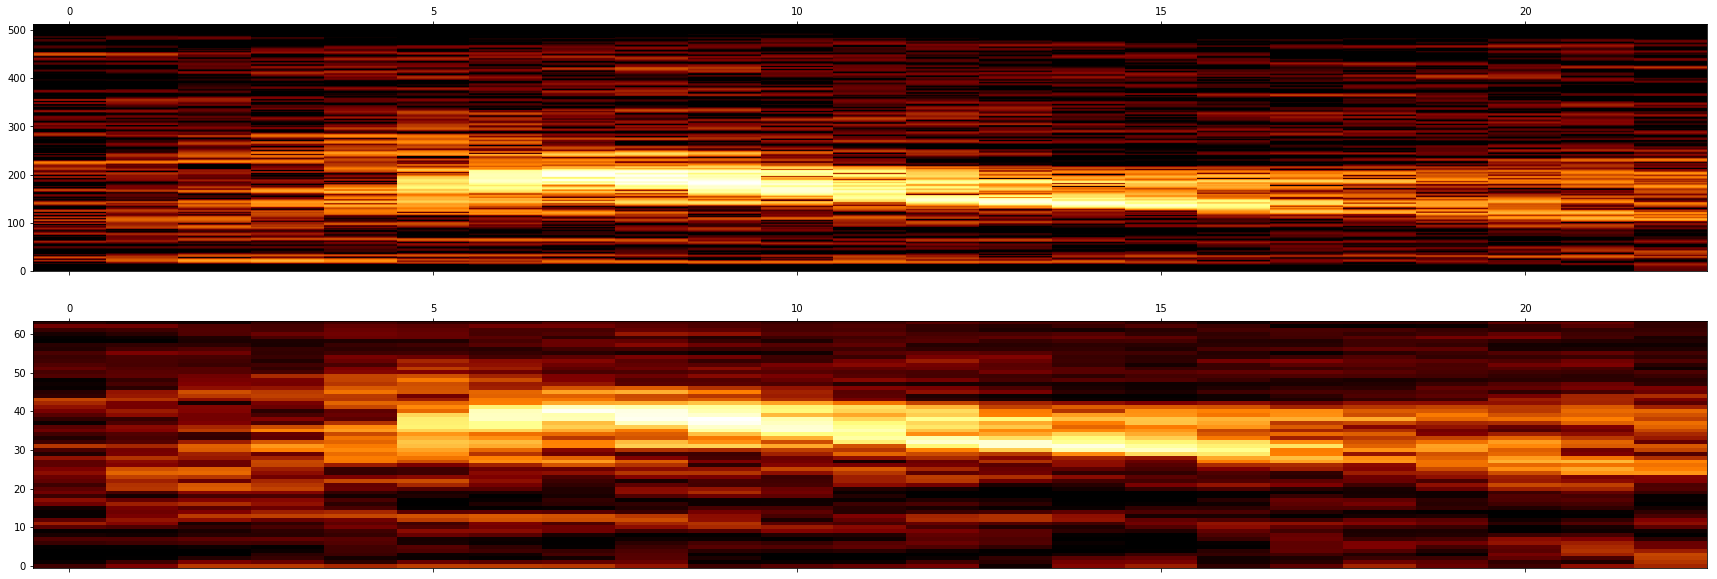

In [75]:
fig, axs = plt.subplots(nrows=2, figsize=(30,10))
axs[0].matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
axs[1].matshow(mel_spec, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
#ax.axis('off')

In [79]:
nrow = 3
ncol = 10
zoom_x = 3
zoom_y = 2

Great Blue Heron


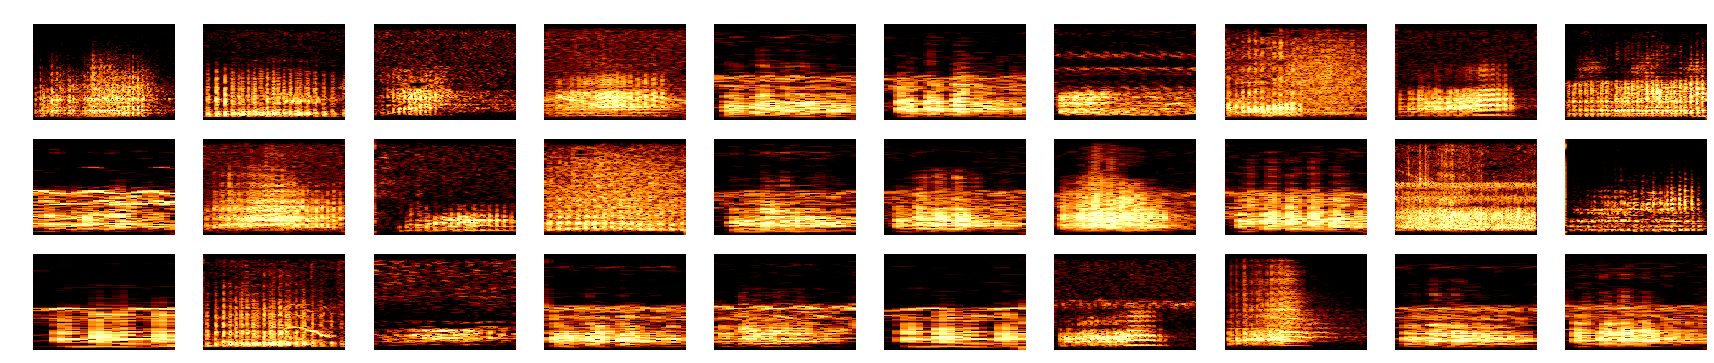

Indigo Bunting


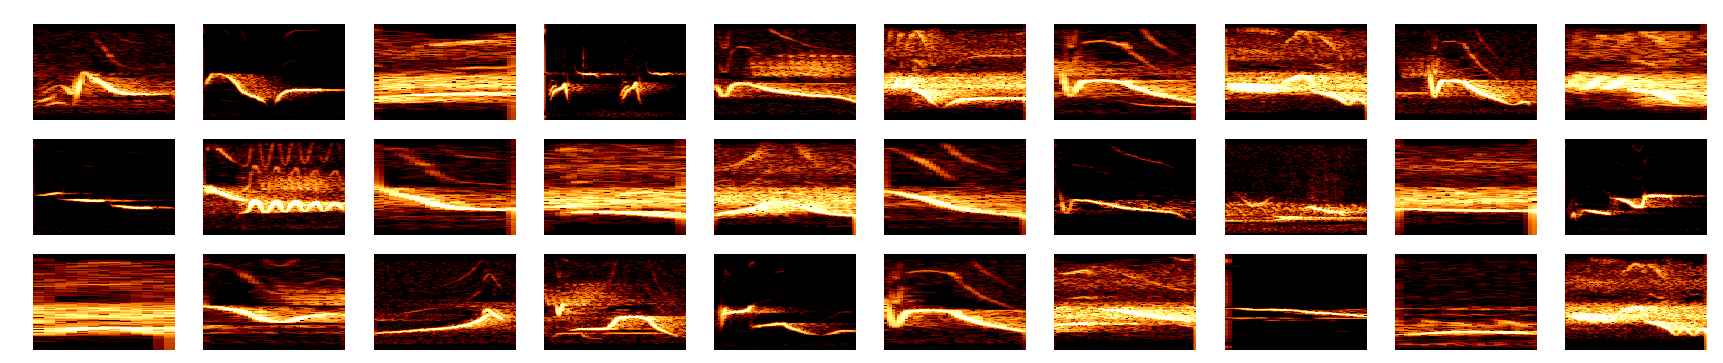

American Crow


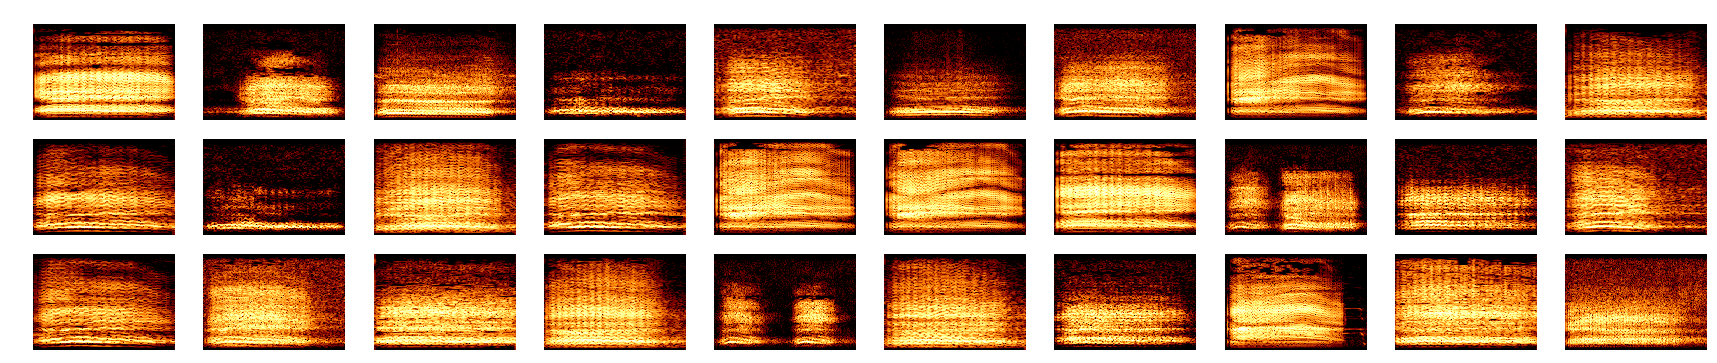

American Yellow Warbler


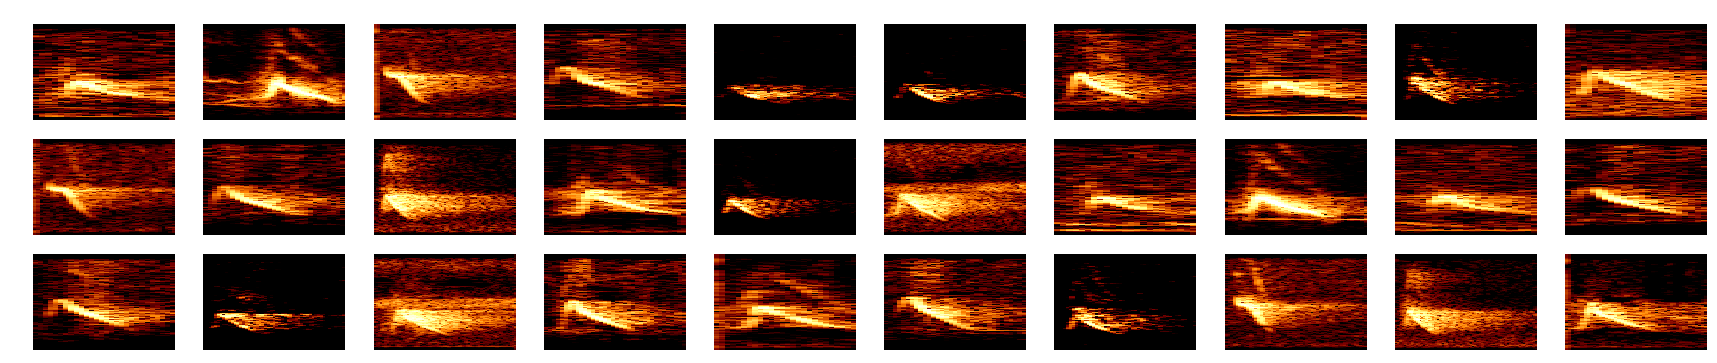

 Blue Jay


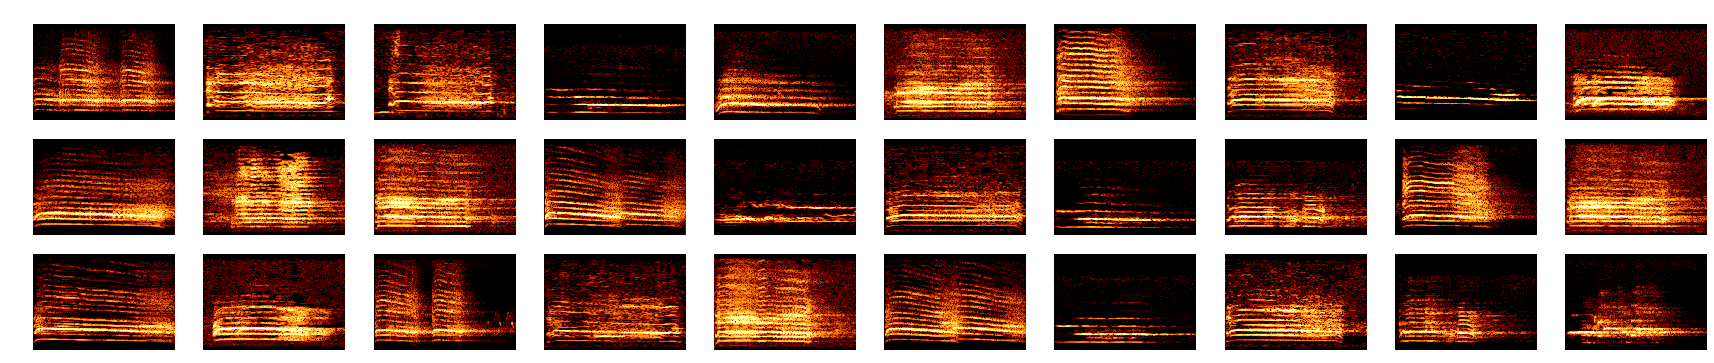

б░unknownб▒ events


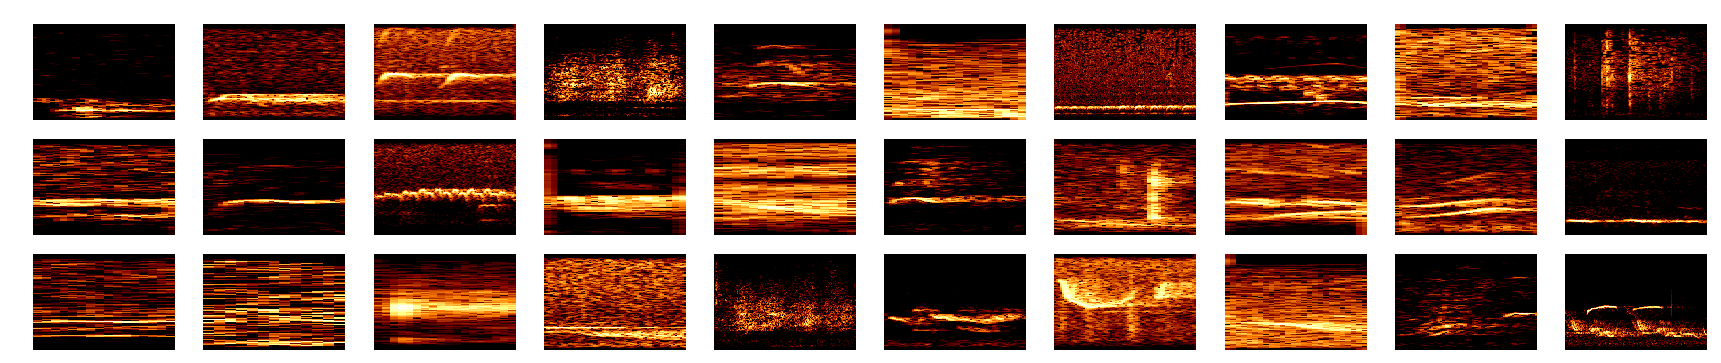

House Finch


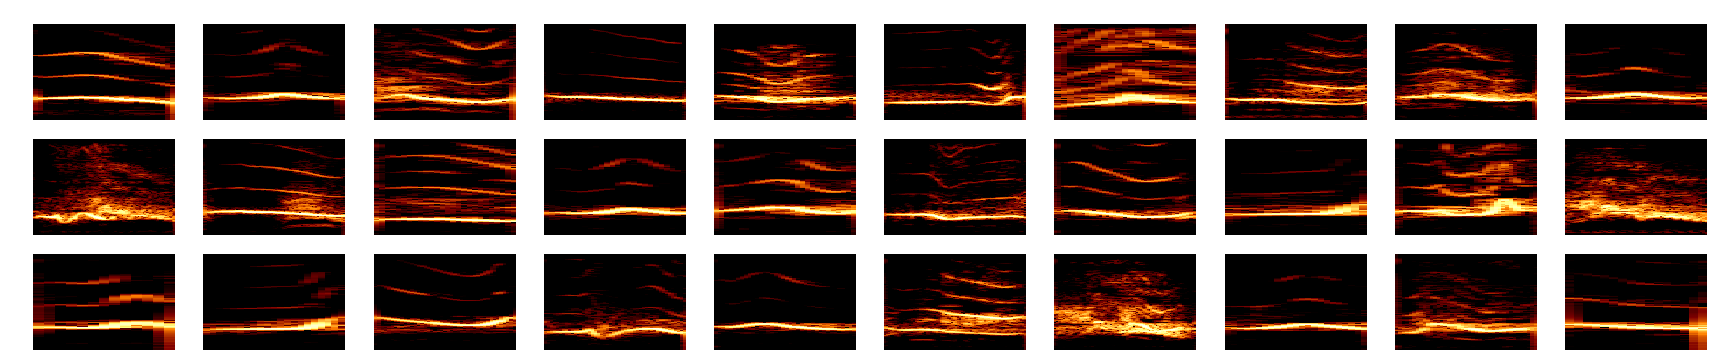

Chipping Sparrow


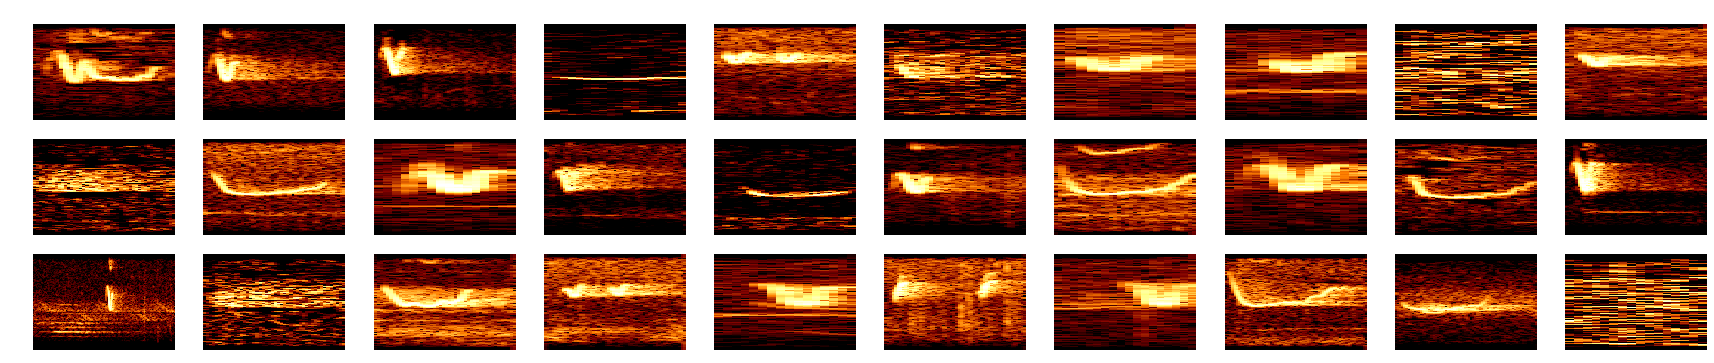

Song Sparrow


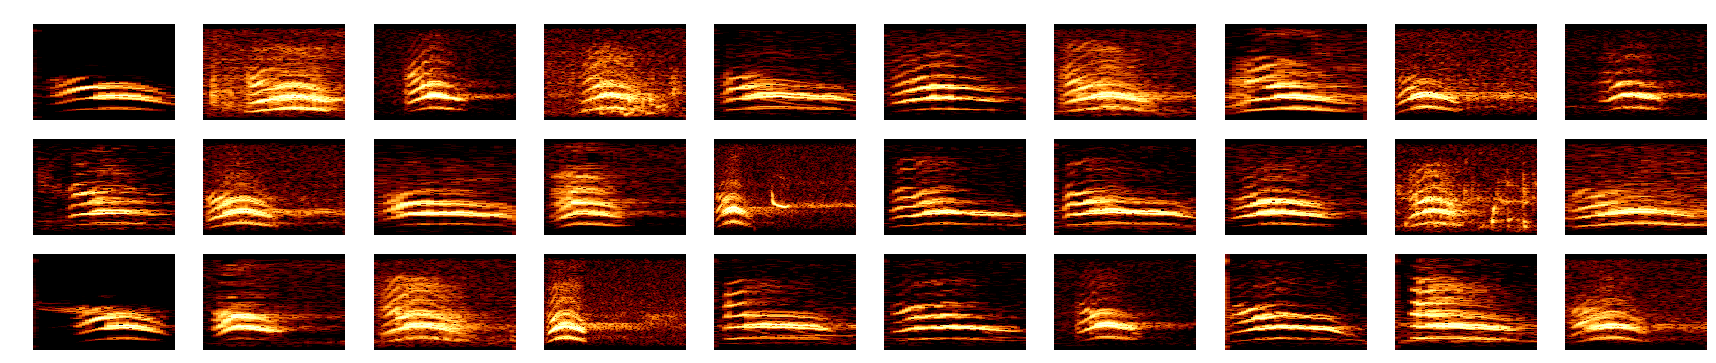

Common Yellowthroat


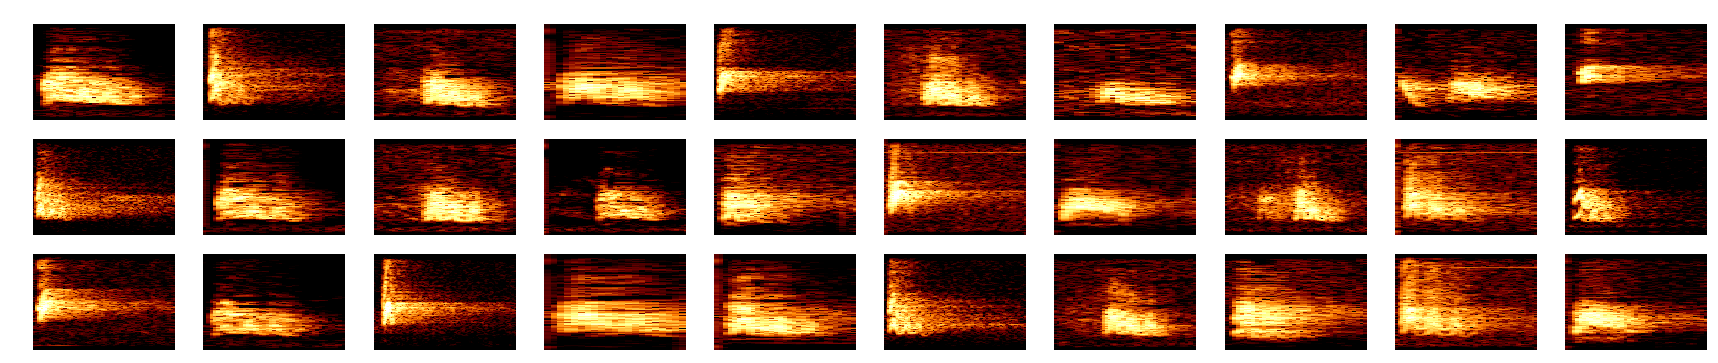

Cedar Waxwing


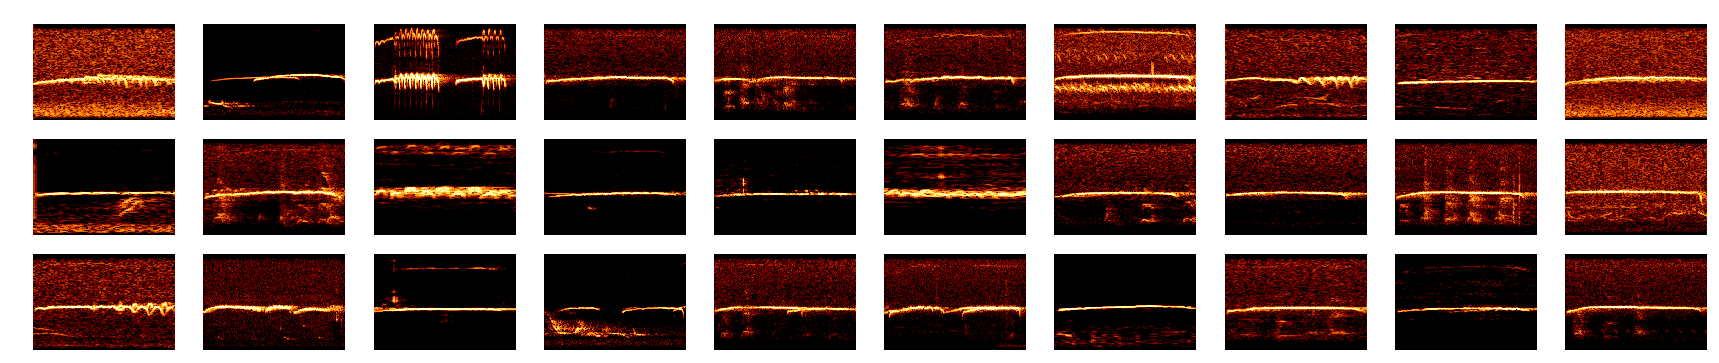

Marsh Wren


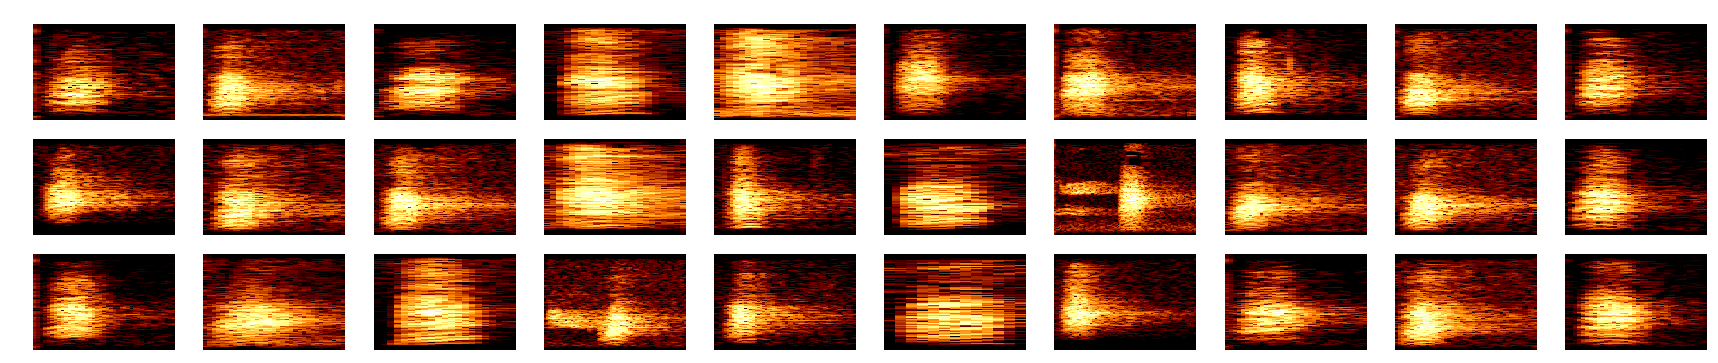

In [80]:
for species in tqdm(wav_df.species.unique()):
    species_wavs = wav_df[(wav_df.species == species)]
    print(species)
    fig, axs = plt.subplots(nrows = nrow, ncols=ncol, figsize=(ncol*zoom_x, nrow*zoom_y))
    for axi in range(nrow*ncol):    
        audio = int16_to_float32(species_wavs.iloc[axi].audio)
        audio = butter_bandpass_filter(audio, lowcut = 500, highcut=15000, fs=rate, order=4)
        spectrogram = sg.spectrogram(audio, hparams)
        mel_spec = np.dot(spectrogram.T, mel_matrix).T
        ax = axs.flatten()[axi] 
        ax.matshow(spectrogram, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
        ax.axis('off')
    plt.show()

### Mean of unknown events could be used for noise reduction